# Importer les librairies

In [4]:
import pandas as pd 
# IMPORTER LES LIBRAIRIES NECESSAIRES A L'ETUDE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Importer les données

In [5]:
data = pd.read_csv("Data/titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex`, `Embarked` avec l'argument `drop_first=True`.

In [6]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    
    """La fonction prépare les données à l'analyse.
    
    Args:
        data (pd.DataFrame): La dataframe originale
        
    Returns:
        pd.DataFrame: La dataframe preprocessé et prête à être analysée.
    """
    
    # Faire une copy de la dataframe originale
    data_preprocessed = data.copy()
    
    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed = data_preprocessed.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
    
    # Supprimez lignes contenant au moins une valeur manquante
    data_preprocessed = data_preprocessed.dropna()
    
    # Créer une variable `FamilySize` et supprimez les variables `SibSp` et `Parch`
    data_preprocessed["FamilySize"] = data_preprocessed["SibSp"] + data_preprocessed["Parch"] + 1
    data_preprocessed = data_preprocessed.drop(columns=["SibSp", "Parch"])
    
    # Recalculer le prix du billet
    data_preprocessed["Fare"] = data_preprocessed["Fare"] / data_preprocessed["FamilySize"]
    
    # Encode (OHE) `Sex` & `Embarked`
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Sex", "Embarked"], drop_first=True)
    
    
    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    
    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [7]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,True,False,True
1,1,1,38.0,35.641650,2,False,False,False
2,1,3,26.0,7.925000,1,False,False,True
3,1,1,35.0,26.550000,2,False,False,True
4,0,3,35.0,8.050000,1,True,False,True
...,...,...,...,...,...,...,...,...
885,0,3,39.0,4.854167,6,False,True,False
886,0,2,27.0,13.000000,1,True,False,True
887,1,1,19.0,30.000000,1,False,False,True
889,1,1,26.0,30.000000,1,True,False,False


## 2. Inférence statistique (4 pts)

**Q1: L'âge moyen des passagers du Titanic est-il le même que l'âge moyen de la population en 1912 (28 ans)?**

***1. Identifier la ou les variables d’intérêt et spécifier le type***
  
La variable d'intérêt pour cette question est l'<b>âge</b> des passagers du Titanic, dans notre cas c'est une variable de type <b>quantitative continue</b>.  
- var : Age (quantitative continue)

***2. Réaliser une visualisation appropriée selon les variables***

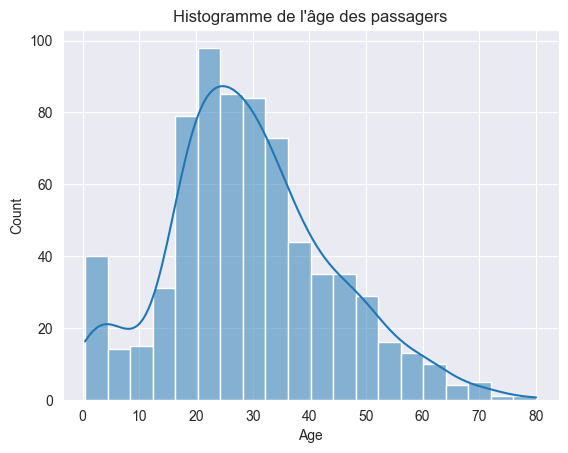

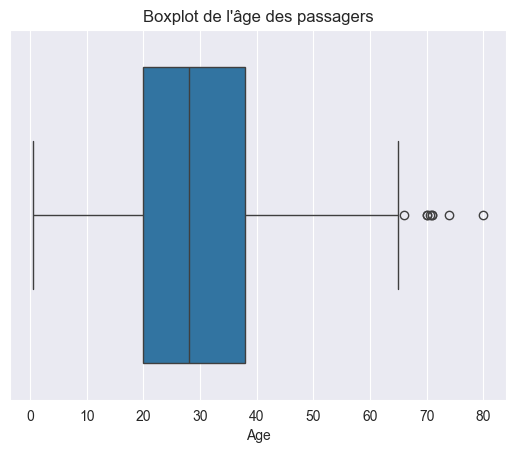

In [8]:
sns.histplot(
    data=data_clean,
    x="Age",
    kde=True
)
plt.title("Histogramme de l'âge des passagers")
plt.show()

sns.boxplot(
    data=data_clean,
    x="Age"
)
plt.title("Boxplot de l'âge des passagers")
plt.show()

***3. Enoncer une hypothèse nulle et alternative***
- <b>H0</b> : il n'existe pas de différence entre l'âge moyen des passagers du Titanic et celui de la population (μ = 28)  
- <b>H1</b> : il existe une différence significative entre l'âge moyen des passagers du Titanic et celui de la population (μ ≠ 28)

***4. Identifier le test statistique approprié***
  
Le test approprié dans ce cas là est un <b>t-test</b>, étant donné qu'on compare la moyenne d'un échantillon avec celle de la population, qu'on a qu'une variable, que cette variable est quantitative et qu'on ne connaît pas la variance ou l'écart-type de la population.

***5. Vérifier la validation des postulats du t-test***
- L'échantillon n'est pas vraiment aléatoire, étant donné qu'il est constitué des passagers du Titanic, qui sont un sous-groupe spécifique de la population (personnes ayant les moyens d'acheter un billet de bâteau et l'envie)
- La taille de l'échantillon est de 712, ce qui est bien supérieur à 30, donc même si la distribution n'est pas idéale (comme montré sur l'histogramme ci-dessus), c'est tout de même validé

In [9]:
n = len(data_clean)

print("La taille de l'échantillon est de : " + str(n))

La taille de l'échantillon est de : 712


***6. Calculer la statistique t et la p-valeur***

Avec une statistique t de ~3.02, on peut dire que la différence entre la moyenne d'âge des passagers du titanic et de celle de la population est conséquente.    
  
Avec une p-valeur de ~0.0026, il y a 0.0026% de chance d'observer une moyenne d'âge aussi étrange, dans un échantillon aléatoire, que celle qu'on a pour les passagers du Titanic, si on assume que H0 est vraie.

In [10]:
ages = np.array(data_clean["Age"])

t, p_valeur = stats.ttest_1samp(ages, popmean=28)

print("La statistique t est de : " + str(t))
print("La p-valeur associée est de : " + str(p_valeur))

La statistique t est de : 3.0233009800374053
La p-valeur associée est de : 0.002590259537786662


***7. Prendre une décision selon la p-valeur (alpha 5%)***

Avec un seuil alpha de 0.05 et notre p-valeur, on a suffisament de preuve pour rejeter l'hypothèse nulle. Les preuves soutiennent le fait qu'il y ait une différence significative entre l'âge moyen des passagers du Titanic et celui de la population.

In [11]:
alpha = 0.05

if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejette l'hypothèse nulle.")
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejette pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejette l'hypothèse nulle.


***8. Interpréter le résultat et évaluer la taille de l’effet***  
  
On aperçoit que, <b>statistiquement</b>, la moyenne d'âge des passagers du Titanic (~29.6) est significativement différente de celle de la population en 1912 (28).  
Avec un d de Cohen de ~0.11, on peut dire que l'effet est faible.  
  
La différence entre la moyenne des âges des passagers du Titanic et de celle de la population en 1912 est statistiquement différente. Mais en réalité, cette différence est faible.

In [12]:
moyenne_ages = np.mean(ages)
ecart_type_ages = np.std(ages, ddof=1)
d_cohen = (moyenne_ages - 28) / ecart_type_ages

print("La moyenne des âges est de : " + str(moyenne_ages))
print("L'écart-type des âges est de : " + str(ecart_type_ages))
print("Le d de Cohen est de : " + str(d_cohen))

La moyenne des âges est de : 29.64209269662921
L'écart-type des âges est de : 14.49293290032352
Le d de Cohen est de : 0.11330299449551398


**Q2: La survie dépend-elle de la classe du passager?**

***1. Identifier la ou les variables d’intérêt et spécifier le type***
  
Les variable que nous avons déterminé pour cette question sont : l'<b>état de survie</b> des passagers du Titanic et leur <b>classe</b>, ce sont les deux des variables de type <b>qualitative nominale</b>.  
- var 1 : Survived (qualitative nominale)  
- var 2 : Pclass (qualitative nominale)

***2. Réaliser une visualisation appropriée selon les variables***

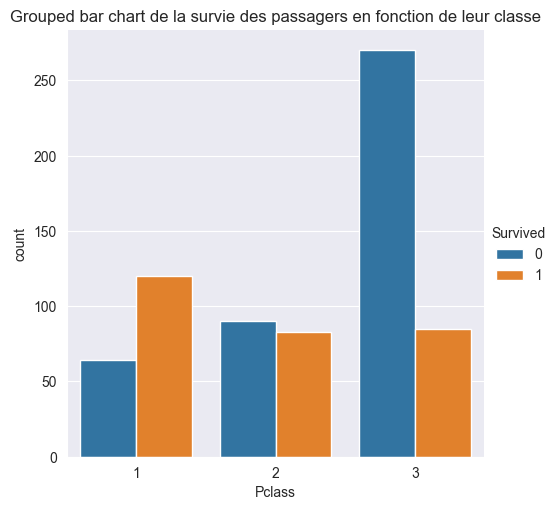

In [13]:
sns.catplot(
    data=data_clean,
    x="Pclass",
    hue="Survived",
    kind="count"
)
plt.title("Grouped bar chart de la survie des passagers en fonction de leur classe")
plt.show()

***3. Enoncer une hypothèse nulle et alternative***
- <b>H0</b> : la survie du passager est indépendante de sa classe  
- <b>H1</b> : la survie du passager n'est pas indépendante de sa classe

***4. Identifier le test statistique approprié***
  
Le test approprié dans ce cas là est un <b>test de 𝜒^2 d’indépendance</b>, étant donné qu'on a deux variables et que ces variables sont qualitatives.

***5. Vérifier la validation des postulats du test de 𝜒^2 d’indépendance***
- L'échantillon n'est pas vraiment aléatoire, étant donné qu'il est constitué des passagers du Titanic, qui sont un sous-groupe spécifique de la population (personnes ayant les moyens d'acheter un billet de bâteau et l'envie)
- Comme montré à l'aide du tableau ci-dessous, il y a plus de 5 valeurs par combinaison, c'est donc validé

In [14]:
tab_contingence = pd.crosstab(data_clean["Survived"], data_clean["Pclass"])

print(tab_contingence)


Pclass      1   2    3
Survived              
0          64  90  270
1         120  83   85


***6. Calculer la statistique et la p-valeur***

Avec une statistique de ~91.08, on peut dire qu'il y a une énorme dépendance entre la survie du passager et sa classe.  
  
Avec une p-valeur de ~1.67e-20, il y a un pourcentage extrêmement petit d'observer une dépendance aussi étrange entre la survie et la classe des passager, dans un échantillon aléatoire, si on assume que H0 est vraie.

In [15]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(tab_contingence)

print("La statistique est de : " + str(chi2_stat))
print("La p-valeur est de : " + str(p_val))
print("Le degré de liberté est de : " + str(dof))
print("Les valeurs attendues sont : " + str(ex))

La statistique est de : 91.08074548791019
La p-valeur est de : 1.6675060315554636e-20
Le degré de liberté est de : 2
Les valeurs attendues sont : [[109.57303371 103.02247191 211.40449438]
 [ 74.42696629  69.97752809 143.59550562]]


***7. Prendre une décision selon la p-valeur (alpha 5%)***

Avec un seuil alpha de 0.05 et notre p-valeur, on a suffisament de preuve pour rejeter l'hypothèse nulle. Les preuves soutiennent le fait qu'il y ait une dépendance forte entre la survie et la classe du passager.

In [16]:
if p_val < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejette l'hypothèse nulle.")
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejette pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejette l'hypothèse nulle.


***8. Interpréter le résultat et évaluer la taille de l’effet***  
  
On aperçoit que, <b>statistiquement</b>, il y a une dépendance assez significative entre la survie des passagers et leur classe.  
Avec un V de Cramer de ~0.36, on peut dire que l'effet est moyen.

Donc, plus le passager a une classe élevée (1ère classe étant la plus élevée), plus il a de chance de survivre.

In [17]:
v_cramer = np.sqrt(chi2_stat / (len(data_clean) * (min(tab_contingence.shape) - 1)))

print("Le V de Cramer est de : " + str(v_cramer))

Le V de Cramer est de : 0.35766240415815087


**Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés?**

***1. Identifier la ou les variables d’intérêt et spécifier le type***
  
Les variable que nous avons déterminé pour cette question sont : l'<b>âge</b> des passagers du Titanic et leur <b>état de survie</b>, l'âge est de type <b>quantitative continue</b> et l'état de survie est de type <b>qualitative nominale</b>.  
- var 1 : Age (quantitative discrète)  
- var 2 : Survived (qualitative nominale)

***2. Réaliser une visualisation appropriée selon les variables***

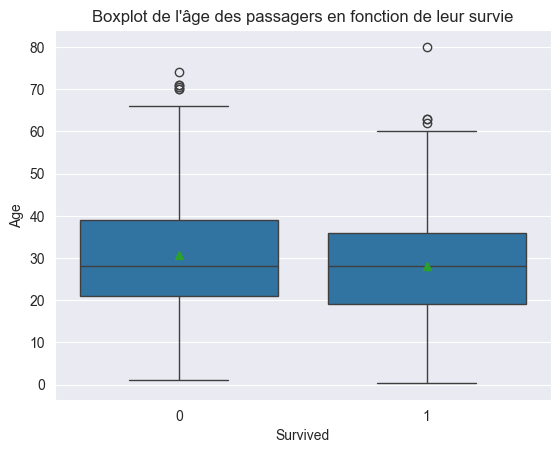

In [18]:
sns.boxplot(
    data=data_clean,
    x="Survived",
    y="Age",
    showmeans=True
)
plt.title("Boxplot de l'âge des passagers en fonction de leur survie")
plt.show()

***3. Enoncer une hypothèse nulle et alternative***
- <b>H0</b> : il n'existe pas de différence d'âge entre les passagers qui ont survécu et ceux qui sont décédés (μ1 = μ2)  
- <b>H1</b> : il existe une différence d'âge significative entre les passagers qui ont survécu et ceux qui sont décédés (μ1 ≠ μ2)

***4. Identifier le test statistique approprié***
  
Le test approprié dans ce cas là est un <b>t-test à deux échantillons</b>, étant donné qu'on a deux variables, qu'une de ces variables est de type quantitative et que l'autre est de type qualitative (dichotomique).

***5. Vérifier la validation des postulats du t-test à deux échantillons***
- Les échantillons ne sont pas vraiment aléatoire, étant donné qu'ils sont constitués des passagers du Titanic, qui sont un sous-groupe spécifique de la population (personnes ayant les moyens d'acheter un billet de bâteau et l'envie)
- Les échantillons sont indépendants car il y a un échantillon qui concerne les passagers qui n'ont pas survécu tandis que l'autre concerne ceux qui ont survécu
- La taille des échantillons, qui est de 424 pour ceux qui n'ont pas survécu et 288 pour ceux qui ont survécu, est bien supérieur à 30

In [19]:
n_not_survived = len(data_clean[data_clean["Survived"] == 0])
n_survived = len(data_clean[data_clean["Survived"] == 1])

print("La taille de l'échantillon des passagers n'ayant pas survécu est de : " + str(n_not_survived))
print("La taille de l'échantillon des passagers ayant survécu est de : " + str(n_survived))

La taille de l'échantillon des passagers n'ayant pas survécu est de : 424
La taille de l'échantillon des passagers ayant survécu est de : 288


***6. Calculer la statistique et la p-valeur***

Avec une statistique t de ~2.18, on peut dire que la différence entre la moyenne d'âge des passagers du titanic qui ont survécu et de celle des passagers qui n'ont pas survécu est conséquente.  
  
Avec une p-valeur de ~0.03, il y a 0.03% de chance d'observer une différence aussi étrange entre ces moyennes d'âge, dans un échantillon aléatoire, si on assume que l'hypthèse nulle est vraie.

In [20]:
ages_not_survived = np.array(data_clean[data_clean["Survived"] == 0]["Age"])
ages_survived = np.array(data_clean[data_clean["Survived"] == 1]["Age"])

t, p_valeur = stats.ttest_ind(
    ages_not_survived,
    ages_survived,
    alternative="two-sided",
    equal_var=False
)

print("La statistique t est de : " + str(t))
print("La p-valeur associée est de : " + str(p_valeur))

La statistique t est de : 2.184486214939826
La p-valeur associée est de : 0.02931497754601072


***7. Prendre une décision selon la p-valeur (alpha 5%)***

Avec un seuil alpha de 0.05 et notre p-valeur, on a suffisament de preuve pour rejeter l'hypothèse nulle. Les preuves soutiennent le fait qu'il y ait une différence significative entre les deux moyennes.

In [21]:
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejette l'hypothèse nulle.")
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejette pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejette l'hypothèse nulle.


***8. Interpréter le résultat et évaluer la taille de l’effet***  
  
On aperçoit que, <b>statistiquement</b>, la moyenne d'âge des passagers du Titanic ayant survécu (~28.19) est significativement différente de celle de ceux qui n'ont pas survécu (~30.63).  
Avec un d de Cohen de ~0.17 en valeur absolue, on peut dire que l'effet est faible.  
  
La différence entre la moyenne des âges des passagers du Titanic ayant survécu et de celle de ceux qui n'ont pas survécu est statistiquement différente. Mais en réalité, cette différence est faible.

In [22]:
moyenne_ages_survived = np.mean(ages_survived)
moyenne_ages_not_survived = np.mean(ages_not_survived)
d_cohen = (moyenne_ages_survived - moyenne_ages_not_survived) / ecart_type_ages

print("La moyenne des âges des passagers ayant survécu est de : " + str(moyenne_ages_survived))
print("La moyenne des âges des passagers n'ayant pas survécu est de : " + str(moyenne_ages_not_survived))
print("L'écart-type des âges est de : " + str(ecart_type_ages))
print("Le d de Cohen est de : " + str(d_cohen))

La moyenne des âges des passagers ayant survécu est de : 28.19329861111111
La moyenne des âges des passagers n'ayant pas survécu est de : 30.62617924528302
L'écart-type des âges est de : 14.49293290032352
Le d de Cohen est de : -0.16786668722640677


**Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets?**

***1. Identifier la ou les variables d’intérêt et spécifier le type***
  
Les variable que nous avons déterminé pour cette question sont : l'<b>âge</b> des passagers du Titanic et le <b>prix du billet</b>, ce sont les deux des variables de type <b>quantitative continue</b>.  
- var 1 : Age (quantitative continue)
- var 2 : Fare (quantitative continue)

***2. Réaliser une visualisation appropriée selon les variables***

L'axy y est en échelle logarithmique afin de mieux voir le scatter plot.

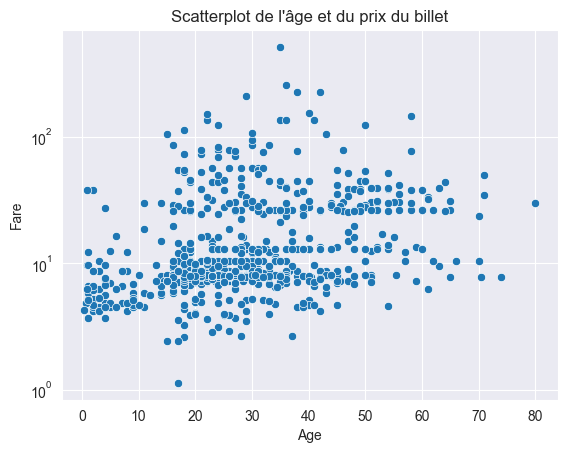

In [23]:
sns.scatterplot(
    data=data_clean,
    x="Age",
    y="Fare"
)
plt.yscale("log")
plt.title("Scatterplot de l'âge et du prix du billet")
plt.show()

***3. Enoncer une hypothèse nulle et alternative***
- <b>H0</b> : il n'y a pas de corrélation entre l'âge des passagers et le prix du billet (𝜌 = 0)
- <b>H1</b> : il y a une corrélation significative entre l'âge des passagers et le prix du billet (𝜌 ≠ 0)

***4. Identifier le test statistique approprié***
  
Le test approprié dans ce cas là est un <b>t-test pour la corrélation</b>, étant donné qu'on a deux variables, que ces deux variables sont de type quantitative.

***5. Vérifier la validation des postulats du t-test pour la corrélation***
- Les données sont quantitatives mais l'échantillon n'est pas vraiment aléatoire, étant donné qu'il est constitué des passagers du Titanic, qui sont un sous-groupe spécifique de la population (personnes ayant les moyens d'acheter un billet de bâteau et l'envie)
- Le scatter plot ne montre aucune liaison
- Il y a certaines valeurs qui sont abberantes
- Les deux variables ne suivent pas une loi normale

Comme les postulats ne sont pas respectés, il n'y a pas de raison de poursuivre cette analyse, car les résultats ne voudront pas dire grand chose.

## 3. Data mining (2 pts)

**Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.**

In [24]:
print(data_clean.dtypes)

data_clean_reg_log = data_clean.astype({col: 'int' for col in data_clean.select_dtypes(include=['bool']).columns})

X = data_clean_reg_log.drop(columns=["Survived"])
y = data_clean_reg_log["Survived"]

Survived        int64
Pclass          int64
Age           float64
Fare          float64
FamilySize      int64
Sex_male         bool
Embarked_Q       bool
Embarked_S       bool
dtype: object


In [25]:
model = sm.Logit(
    y,
    sm.add_constant(X)
)

model_fit = model.fit()

print(model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.445519
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                  0.3398
Time:                        14:14:00   Log-Likelihood:                -317.21
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.324e-66
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7251      0.659      8.691      0.000       4.434       7.016
Pclass        -1.1795      0.

In [26]:
coefs = model_fit.params.tolist()

coefs

[5.7250986011401706,
 -1.1794912526464782,
 -0.04183154633377716,
 0.003010467594464039,
 -0.193409387543726,
 -2.65474610140251,
 -0.8290537688375387,
 -0.4111051053739089]

In [27]:
odds_ratio = np.exp(model_fit.params)

pd.DataFrame(odds_ratio, columns=["Odds Ratio"])

,Odds Ratio
const,306.463481
Pclass,0.307435
Age,0.959031
Fare,1.003015
FamilySize,0.824145
Sex_male,0.070317
Embarked_Q,0.436462
Embarked_S,0.662917


**Détails par variable**
  
***Pclass (coef = -1.1795, p=0.000, OR ≈ 0.31):***
- Sens : Un coefficient négatif de -1.1795 signifie que plus la classe (Pclass) augmente (i.e. passer de 1 → 2 → 3), plus la probabilité de survie diminue.
- Magnitude (odds ratio) : e^(-1.1795) ≈ 0.31. Autrement dit, si Pclass augmente de 1 unité (ex. de la 1ʳᵉ à la 2ᵉ classe, ou de la 2ᵉ à la 3ᵉ), les chances (odds) de survie sont multipliées par ~0.31 (soit diminuées d’environ 69%).
- Significativité : p=0.000, effet statistiquement très significatif.  
  
***Age (coef = -0.0418, p=0.000, OR ≈ 0.96):***
- Sens : Un coefficient négatif indique qu’à mesure que l’âge augmente, la probabilité de survie diminue légèrement.
- Magnitude : e^(-0.0418) ≈ 0.96, donc chaque année supplémentaire est associée à une réduction d’environ 4% des chances de survie (toutes choses égales par ailleurs).
- Significativité : p=0.000, effet statistiquement très significatif.  
  
***Fare (coef = 0.0030, p=0.457, OR ≈ 1.003):***
- Sens : Le coefficient est légèrement positif, mais pas significatif (p=0.457 > 0.05). On ne peut donc pas conclure que le prix du billet (Fare) exerce un effet notable sur la survie dans ce modèle, une fois les autres variables prises en compte.
- Magnitude : e^(0.0030) ≈ 1.003, ~0.3% d’augmentation des odds par unité supplémentaire de Fare, mais vu la p-valeur, cette estimation n’est pas jugée fiable/statistiquement significative.  
  
***FamilySize (coef = -0.1934, p=0.009, OR ≈ 0.82):***
- Sens : Coefficient négatif, donc plus la taille de la famille est grande, plus les chances de survie diminuent selon ce modèle.
- Magnitude : e^(-0.1934) ≈ 0.82, soit une baisse de ~18% des chances de survie par personne supplémentaire dans la famille.
- Significativité : p=0.009 (< 0.05), donc effet jugé significatif.  
  
***Sex_male (coef = -2.6547, p=0.000, OR ≈ 0.07):***
- Sens : Être un homme (Sex_male=1) diminue fortement la probabilité de survie (référence = femme).
- Magnitude : e^(-2.6547) ≈ 0.07, c’est-à-dire que les hommes ont ~93% de chances en moins (1 − 0.07 = 0.93) de survivre par rapport aux femmes, toutes choses égales par ailleurs.
- Significativité : p=0.000, effet hautement significatif.  
  
***Embarked_Q (coef = -0.8291, p=0.165, OR ≈ 0.44):***
- Sens : L’embarquement au port ‘Q’ a un coefficient négatif, mais la p-valeur (0.165) > 0.05.
- Conclusion : On ne peut pas conclure à un effet significatif de l’embarquement à ‘Q’ sur la survie.  
  
***Embarked_S (coef = -0.4111, p=0.128, OR ≈ 0.66):***  
- Sens : L’embarquement au port ‘S’ donne un coefficient négatif de -0.41, mais p=0.128 > 0.05.
- Conclusion : Pas de preuve statistique qu’embarquer à ‘S’ influe significativement sur les chances de survie, dans ce modèle.

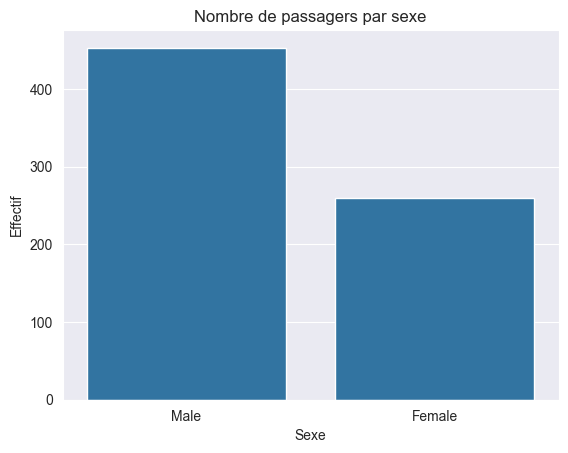

Male/Female ratio = 1.749034749034749


In [28]:
# mappage pour plus de clarté
data_clean['Sex_label'] = data_clean['Sex_male'].map({True: 'Male', False: 'Female'})

# bar chart du nombre de passagers Male vs Female
sns.countplot(data=data_clean, x="Sex_label")
plt.title("Nombre de passagers par sexe")
plt.xlabel("Sexe")
plt.ylabel("Effectif")
plt.show()
#ratio d'homme pour chaque femme
print(
    "Male/Female ratio =",
    data_clean['Sex_male'].value_counts()[True] / data_clean['Sex_male'].value_counts()[False]
)

**Discussion**

***Sex_male (coef fortement négatif) :***  
Le fait d’être un homme sur le Titanic diminue fortement la probabilité de survie, et cela s’explique en partie par la règle tacite “Femmes et enfants d’abord.” D'ailleurs, et comme vu dans le graphe ci dessus, il est important de noter qu’il y avait environ 1,7 fois plus d’hommes que de femmes à bord (donc, pour chaque groupe de 10 femmes, on comptait 17 hommes). Dans un contexte où le nombre de places sur les canots de sauvetage était limité, cette proportion plus élevée de passagers masculins a sans doute amplifié la concurrence pour s’échapper. Ainsi, non seulement les hommes étaient souvent priés de laisser la priorité aux femmes et aux enfants, mais ils étaient également plus nombreux, ce qui renforce la probabilité que beaucoup d’entre eux se retrouvent sans place sur les canots.  
  
***Pclass (négatif) :***  
Plus la classe est élevée (1ère classe), meilleures sont les chances de survie. Les passagers de 3ème classe ont souvent été logés dans des ponts plus bas, avec un accès plus compliqué aux canots de sauvetage (https://courses.bowdoin.edu/history-2203-fall-2020-kmoyniha/reflection/). La variable Pclass capture donc le déséquilibre dans les opportunités de fuite, l’accès à l’information et à la proximité des canots.

***Age (négatif) :***  
Plus on vieillit, moins on a la force ou l’agilité pour se frayer un chemin vers les canots. Par ailleurs, si l’on observe que les plus jeunes survivent davantage, cela peut venir du fait qu’on ait effectivement privilégié les “enfants” dans le sauvetage. Ce résultat nuance le “Femmes et enfants d’abord” pour les plus âgés, qui ont peut-être eu moins de capacité ou de chances de s’en sortir.

***FamilySize (négatif) :***  
Un effet parfois inattendu, mais dans un scénario dramatique comme le Titanic, voyager en famille nombreuse pouvait paradoxalement réduire les chances de survie. On pourrait imaginer qu’une personne tentant de secourir plusieurs proches ralentit sa propre évacuation. Par exemple, un père de famille qui essaie de réunir sa femme (ou son homme!!!) et quatre enfants est susceptible de perdre un temps précieux, voire de se sacrifier pour en sauver un maximum.

**Q2: Effectuer une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.**

In [29]:
model = DecisionTreeClassifier(max_depth=4)

model_fit = model.fit(X, y)

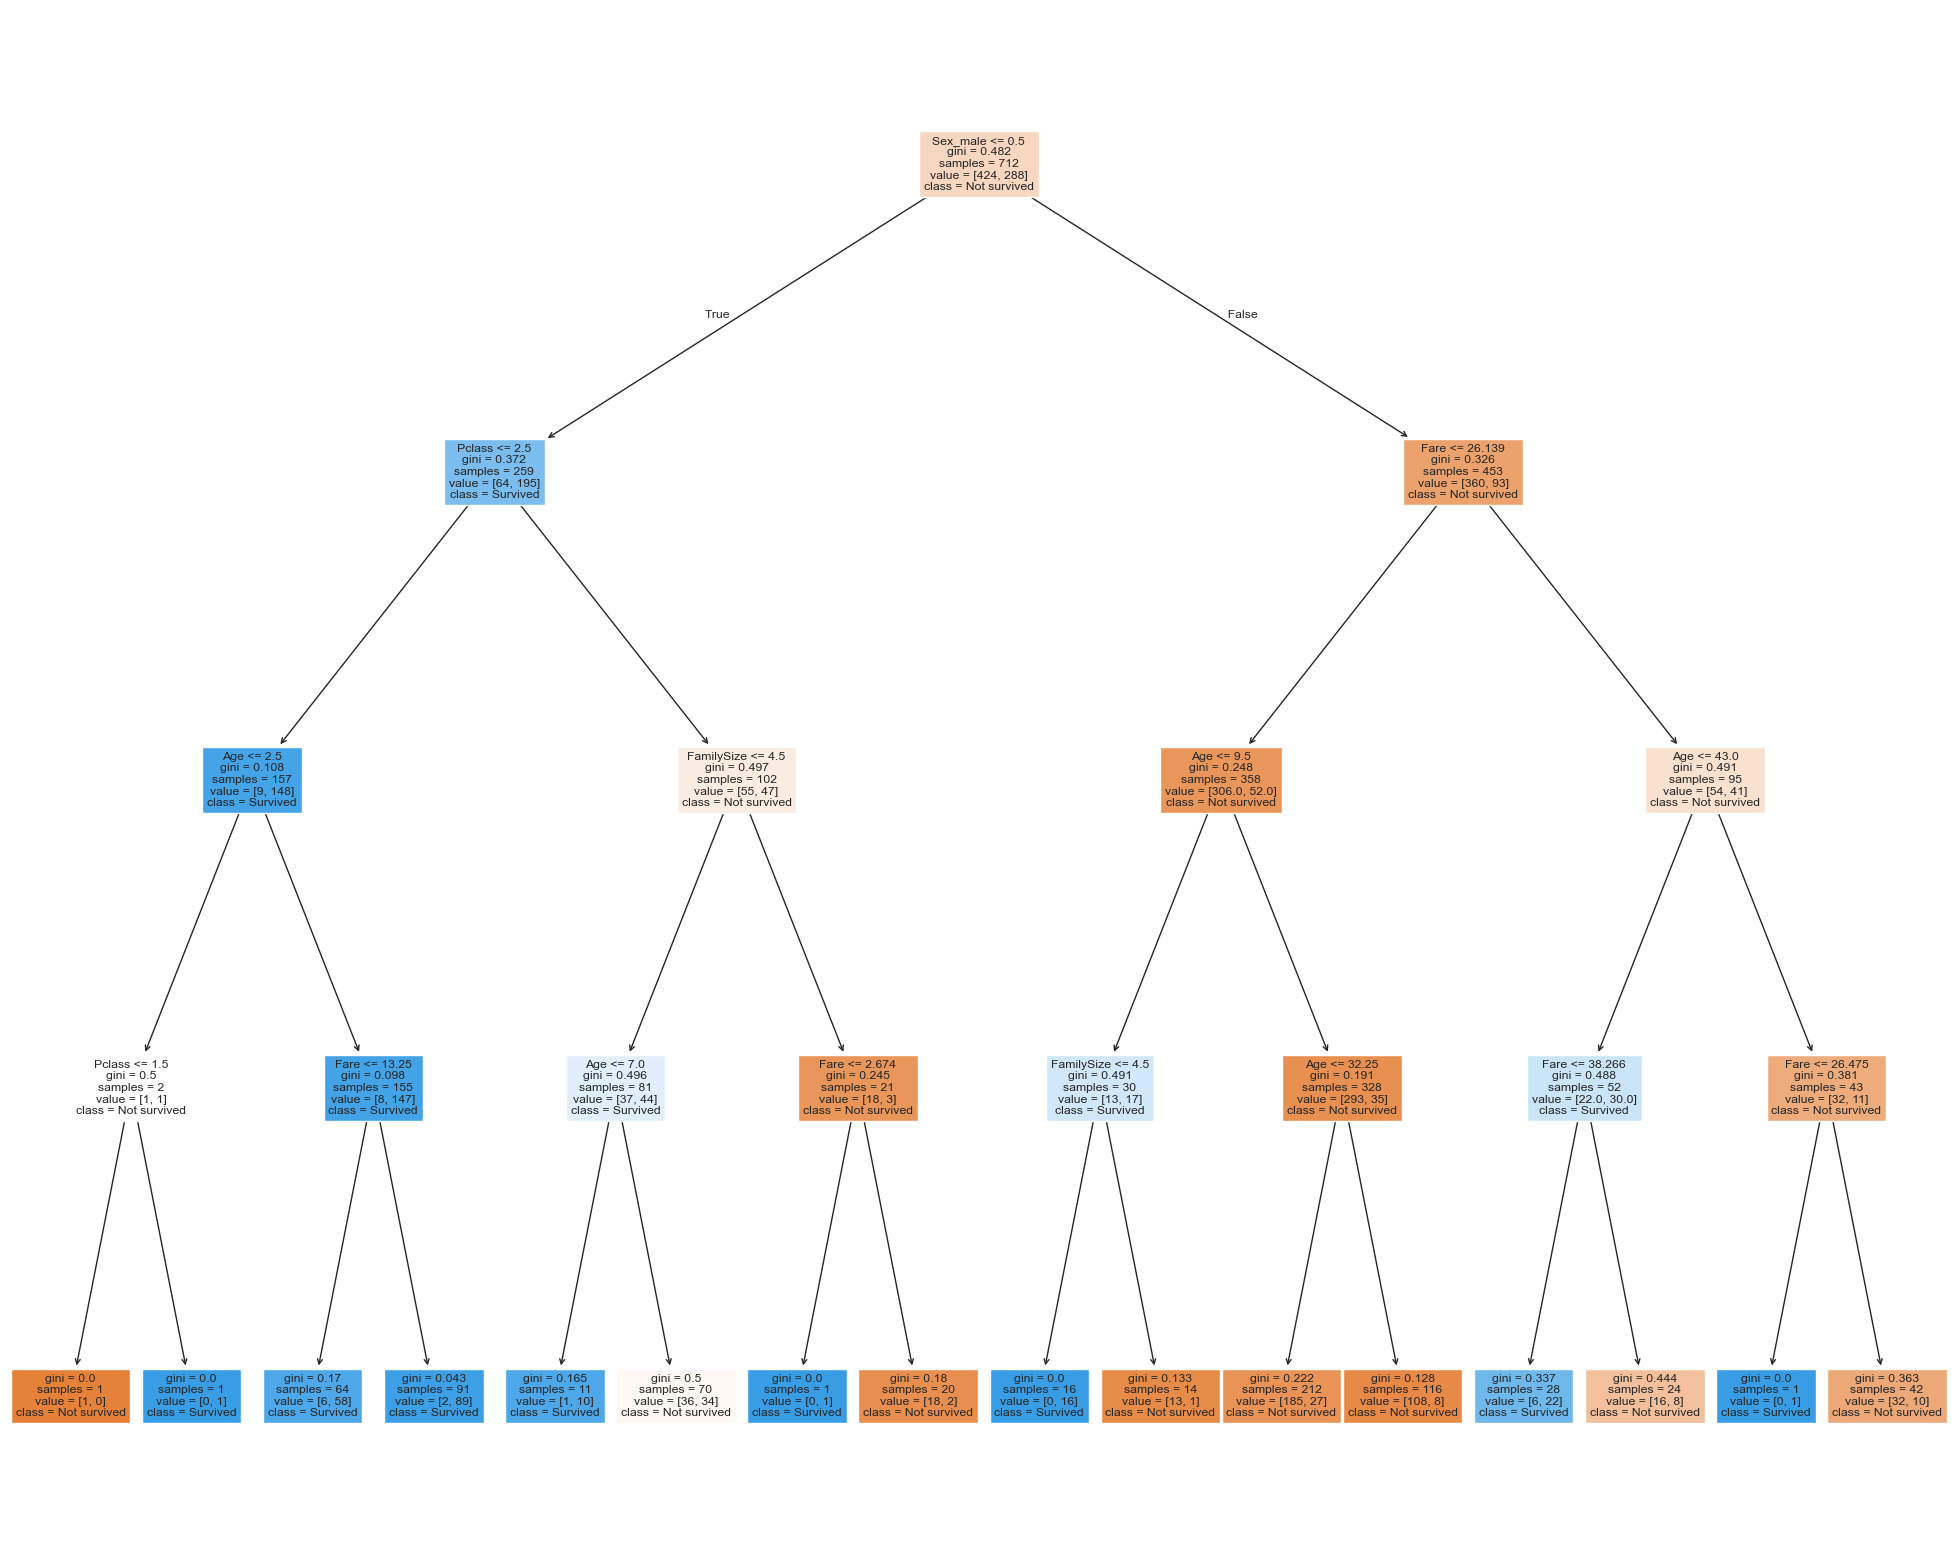

In [30]:
fig = plt.figure(figsize=(25, 20))
_ = plot_tree(
    model,
    feature_names=X.columns.tolist(),
    class_names=["Not survived", "Survived"],
    filled=True
)

***Racine :***

La toute première question est : Sex_male <= 0.5?

Si la réponse est “True” (donc Sex_male=0, c’est-à-dire une femme), on part vers la branche de gauche.

Si c’est “False” (donc Sex_male=1, un homme), on va vers la branche de droite.

C’est cohérent avec l’importance de la variable “Sexe” dans la survie : l’arbre sépare tout de suite femmes et hommes.

***Branche “Femmes” (gauche), 2ᵉ question : Pclass <= 2.5?***

Si “Oui” (première ou deuxième classe), on continue le sous-arbre (encore à gauche) où l’on affine sur l’Âge ou Fare.

Si “Non” (troisième classe), on aboutit à une autre sous-branche.

Cette décision indique que chez les femmes, être en 1ʳᵉ/2ᵉ classe versus en 3ᵉ classe est un critère majeur pour la survie.

***Exemple de nœud plus bas : Age <= 2.5 (femmes, 1ʳᵉ/2ᵉ classe).***

Si “Oui” (donc Age ≤ 2,5 ans !), il s’agit d’enfants en très bas âge : presque tous survivent (le nœud final est “Survived”).

Si “Non”, l’arbre regarde parfois Fare <= 13.2 ou d’autres variables pour départager.

On voit ici le fameux “Femmes et enfants d’abord”, avec un taux de survie encore plus élevé si l’enfant est vraiment jeune.

***Branche “Hommes” (droite), 2ᵉ question : Fare <= 26.159***

Pour les hommes ayant payé un billet peu cher (moins de ~26 £), on va sur la branche de gauche, autrement on descend à droite où on teste ensuite Age, FamilySize, etc.

Cela reflète l’idée qu’un homme en 3ᵉ classe (ou billet bon marché) est souvent dans une situation défavorable ; l’arbre affine ensuite selon l’âge ou la taille de la famille.

***Exemple de feuille :***
on voit par exemple une feuille notée “class = Survived” avec un certain nombre d’observations, par exemple si Sex_male=0.5 (femme), Pclass <= 2.5, Age <= 2.5, etc. Ce nœud final indique qu’une très large majorité des observations sur ce chemin ont survécu, donc l’arbre les classe comme “Survived”.

***FamilySize <= 4.5 apparaît aussi :***

L’arbre juge qu’au-delà d’une famille de plus de 4 ou 5 personnes, les chances de survie sont moindres (dans plusieurs branches). On voit donc que chez des hommes ou femmes avec un FamilySize élevé, l’arbre tend à prédire “Not Survived”.

En résumé, l’arbre hiérarchise ainsi : d’abord le sexe (variable la plus discriminante), puis la classe et le prix du billet, puis l’âge (avec un effet très marqué pour les tout-petits), et enfin la taille de la famille. Chaque chemin aboutit à une décision (Survived / Not Survived) en fonction du nœud terminal.